In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import folium
from haversine import haversine, Unit
from geopy.geocoders import Nominatim
from folium.plugins import MarkerCluster
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
%matplotlib inline

# 관련 라이브러리 임포트 
import matplotlib.font_manager as fm

#  한글글꼴로 변경
# plt.rcParams['font.family'] = '한글글꼴명'
plt.rcParams['font.size'] = 22.0
# plt.rcParams['font.family'] = 'batang'
plt.rcParams['font.family'] = 'Malgun Gothic'

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
matplotlib.rcParams['axes.unicode_minus'] = False

# 그래프 기본 크기 설정 
plt.rcParams['figure.figsize'] = [20, 6]

import warnings
warnings.filterwarnings('ignore')

In [2]:
jeon = pd.read_excel('data/아파트(매매)_실거래가_20220913150228.xlsx')
jeon

,시군구,단지명,전용면적(㎡),거래금액(만원)
0,서울특별시 강남구 개포동,개포6차우성아파트1동~8동,79.97,124000
1,서울특별시 강남구 개포동,개포6차우성아파트1동~8동,79.97,123500
2,서울특별시 강남구 개포동,개포6차우성아파트1동~8동,54.98,91500
3,서울특별시 강남구 개포동,개포우성3차,161.00,185000
4,서울특별시 강남구 개포동,개포우성3차,133.46,175000
...,...,...,...,...
8544,서울특별시 중랑구 중화동,한신아파트(103~109),59.76,37500
8545,서울특별시 중랑구 중화동,한신아파트(103~109),59.76,35500
8546,서울특별시 중랑구 중화동,한신아파트(103~109),59.76,34800
8547,서울특별시 중랑구 중화동,한신아파트(103~109),84.03,44300


In [3]:
jeon['전용면적(㎡)'] = jeon['전용면적(㎡)'].round(-1)
jeon['단지명'] = jeon['단지명'].str.replace(r'\([^)]*\)', '', regex=True)
jeon.to_excel('data/jeon.xlsx')
jeon = pd.read_excel('data/jeon.xlsx')
jeon['ID'] = jeon['시군구'] + ' ' + jeon['단지명'] + ' ' + jeon['전용면적(㎡)'].astype('str')
jeon.head()

,Unnamed: 0,시군구,단지명,전용면적(㎡),거래금액(만원),ID
0,0,서울특별시 강남구 개포동,개포6차우성아파트1동~8동,80,124000,서울특별시 강남구 개포동 개포6차우성아파트1동~8동 80
1,1,서울특별시 강남구 개포동,개포6차우성아파트1동~8동,80,123500,서울특별시 강남구 개포동 개포6차우성아파트1동~8동 80
2,2,서울특별시 강남구 개포동,개포6차우성아파트1동~8동,50,91500,서울특별시 강남구 개포동 개포6차우성아파트1동~8동 50
3,3,서울특별시 강남구 개포동,개포우성3차,160,185000,서울특별시 강남구 개포동 개포우성3차 160
4,4,서울특별시 강남구 개포동,개포우성3차,130,175000,서울특별시 강남구 개포동 개포우성3차 130


In [4]:
jeon.drop(['Unnamed: 0', '전용면적(㎡)'], axis=1, inplace=True)
jeon

,시군구,단지명,거래금액(만원),ID
0,서울특별시 강남구 개포동,개포6차우성아파트1동~8동,124000,서울특별시 강남구 개포동 개포6차우성아파트1동~8동 80
1,서울특별시 강남구 개포동,개포6차우성아파트1동~8동,123500,서울특별시 강남구 개포동 개포6차우성아파트1동~8동 80
2,서울특별시 강남구 개포동,개포6차우성아파트1동~8동,91500,서울특별시 강남구 개포동 개포6차우성아파트1동~8동 50
3,서울특별시 강남구 개포동,개포우성3차,185000,서울특별시 강남구 개포동 개포우성3차 160
4,서울특별시 강남구 개포동,개포우성3차,175000,서울특별시 강남구 개포동 개포우성3차 130
...,...,...,...,...
8544,서울특별시 중랑구 중화동,한신아파트,37500,서울특별시 중랑구 중화동 한신아파트 60
8545,서울특별시 중랑구 중화동,한신아파트,35500,서울특별시 중랑구 중화동 한신아파트 60
8546,서울특별시 중랑구 중화동,한신아파트,34800,서울특별시 중랑구 중화동 한신아파트 60
8547,서울특별시 중랑구 중화동,한신아파트,44300,서울특별시 중랑구 중화동 한신아파트 80


In [5]:
jeon = jeon.groupby('ID').mean()

In [6]:
jeon

,거래금액(만원)
ID,
서울특별시 강남구 개포동 개포6차우성아파트1동~8동 50,91500.000000
서울특별시 강남구 개포동 개포6차우성아파트1동~8동 80,123750.000000
서울특별시 강남구 개포동 개포우성3차 130,175000.000000
서울특별시 강남구 개포동 개포우성3차 160,185000.000000
서울특별시 강남구 개포동 개포주공1단지 40,121678.571429
...,...
서울특별시 중랑구 중화동 삼익아파트.상가동 60,26950.000000
서울특별시 중랑구 중화동 중화동건영아파트 60,23500.000000
서울특별시 중랑구 중화동 청원다미소 80,40000.000000


In [7]:
df = pd.read_excel('data/last_three.xlsx')
df.head()

,Unnamed: 0,ID,거래금액(만원)_22/2,전세금(만원)_22/2,전월차,등락율,전세가율,cluster_22/2,거래금액(만원)_22/1,전세금(만원)_22/1,...,전세가율.17,cluster_18/1,인접역 수,전용면적,건축년도,SchoolDistrict,Brand,BrandPower,위도,경도
0,0,서울특별시 강남구 개포동 개포6차우성아파트1동~8동 80,218666.7,59250.000000,3666.7,1.676844,27.096032,1,215000.0,53331.250000,...,32.655695,1,0,80,1987.0,3,0,0,37.483372,127.053437
1,1,서울특별시 강남구 개포동 개포주공1단지 40,180000.0,10166.666667,0.0,0.000000,5.648148,1,180000.0,10166.666667,...,6.976046,1,1,40,1982.0,3,0,0,37.483381,127.057068
2,2,서울특별시 강남구 개포동 개포주공5단지 60,202800.0,44265.000000,0.0,0.000000,21.826923,1,202800.0,43441.666667,...,31.228215,1,1,60,1983.0,3,0,0,37.487868,127.068988
3,3,서울특별시 강남구 개포동 개포주공5단지 80,282250.0,62400.000000,0.0,0.000000,22.108060,1,282250.0,61000.000000,...,25.364016,1,1,80,1983.0,3,0,0,37.487868,127.068988
4,4,서울특별시 강남구 개포동 개포주공6단지 50,189000.0,43116.666667,0.0,0.000000,22.813051,1,189000.0,41461.250000,...,30.110477,1,1,50,1983.0,3,0,0,37.488481,127.072502


In [8]:
del df['Unnamed: 0']
df.head()

,ID,거래금액(만원)_22/2,전세금(만원)_22/2,전월차,등락율,전세가율,cluster_22/2,거래금액(만원)_22/1,전세금(만원)_22/1,전월차.1,...,전세가율.17,cluster_18/1,인접역 수,전용면적,건축년도,SchoolDistrict,Brand,BrandPower,위도,경도
0,서울특별시 강남구 개포동 개포6차우성아파트1동~8동 80,218666.7,59250.000000,3666.7,1.676844,27.096032,1,215000.0,53331.250000,0.0,...,32.655695,1,0,80,1987.0,3,0,0,37.483372,127.053437
1,서울특별시 강남구 개포동 개포주공1단지 40,180000.0,10166.666667,0.0,0.000000,5.648148,1,180000.0,10166.666667,0.0,...,6.976046,1,1,40,1982.0,3,0,0,37.483381,127.057068
2,서울특별시 강남구 개포동 개포주공5단지 60,202800.0,44265.000000,0.0,0.000000,21.826923,1,202800.0,43441.666667,0.0,...,31.228215,1,1,60,1983.0,3,0,0,37.487868,127.068988
3,서울특별시 강남구 개포동 개포주공5단지 80,282250.0,62400.000000,0.0,0.000000,22.108060,1,282250.0,61000.000000,0.0,...,25.364016,1,1,80,1983.0,3,0,0,37.487868,127.068988
4,서울특별시 강남구 개포동 개포주공6단지 50,189000.0,43116.666667,0.0,0.000000,22.813051,1,189000.0,41461.250000,0.0,...,30.110477,1,1,50,1983.0,3,0,0,37.488481,127.072502


In [9]:
tong = df.iloc[:,107:113]
tong

,인접역 수,전용면적,건축년도,SchoolDistrict,Brand,BrandPower
0,0,80,1987.0,3,0,0
1,1,40,1982.0,3,0,0
2,1,60,1983.0,3,0,0
3,1,80,1983.0,3,0,0
4,1,50,1983.0,3,0,0
...,...,...,...,...,...,...
4086,1,60,1998.0,0,0,0
4087,1,80,2005.0,0,0,0
4088,5,50,1997.0,0,0,0
4089,5,60,1997.1,0,0,0


In [10]:
ID = df.iloc[:,0]
ID

0       서울특별시 강남구 개포동 개포6차우성아파트1동~8동 80
1              서울특별시 강남구 개포동 개포주공1단지 40
2              서울특별시 강남구 개포동 개포주공5단지 60
3              서울특별시 강남구 개포동 개포주공5단지 80
4              서울특별시 강남구 개포동 개포주공6단지 50
                     ...               
4086          서울특별시 중랑구 중화동 중화동건영아파트 60
4087             서울특별시 중랑구 중화동 태능에셈빌 80
4088             서울특별시 중랑구 중화동 한신아파트 50
4089             서울특별시 중랑구 중화동 한신아파트 60
4090             서울특별시 중랑구 중화동 한신아파트 80
Name: ID, Length: 4091, dtype: object

In [11]:
e = pd.merge(ID, jeon, left_on='ID', right_on='ID', how='left')
e.to_excel('data/e.xlsx')

In [12]:
e = pd.read_excel('data/e1.xlsx')
del e['Unnamed: 0']
e

,ID,거래금액(만원),거래금액(만원)_18/1
0,서울특별시 강남구 개포동 개포6차우성아파트1동~8동 80,123750.000000,129125.0
1,서울특별시 강남구 개포동 개포주공1단지 40,121678.571429,145736.8
2,서울특별시 강남구 개포동 개포주공5단지 60,NaN,136666.7
3,서울특별시 강남구 개포동 개포주공5단지 80,NaN,177416.7
4,서울특별시 강남구 개포동 개포주공6단지 50,114400.000000,125900.0
...,...,...,...
4086,서울특별시 중랑구 중화동 중화동건영아파트 60,23500.000000,25000.0
4087,서울특별시 중랑구 중화동 태능에셈빌 80,NaN,35000.0
4088,서울특별시 중랑구 중화동 한신아파트 50,NaN,31756.2
4089,서울특별시 중랑구 중화동 한신아파트 60,35440.000000,36534.6


In [13]:
e = e.fillna(method='bfill', axis=1)
e

,ID,거래금액(만원),거래금액(만원)_18/1
0,서울특별시 강남구 개포동 개포6차우성아파트1동~8동 80,123750.0,129125.0
1,서울특별시 강남구 개포동 개포주공1단지 40,121678.571429,145736.8
2,서울특별시 강남구 개포동 개포주공5단지 60,136666.7,136666.7
3,서울특별시 강남구 개포동 개포주공5단지 80,177416.7,177416.7
4,서울특별시 강남구 개포동 개포주공6단지 50,114400.0,125900.0
...,...,...,...
4086,서울특별시 중랑구 중화동 중화동건영아파트 60,23500.0,25000.0
4087,서울특별시 중랑구 중화동 태능에셈빌 80,35000.0,35000.0
4088,서울특별시 중랑구 중화동 한신아파트 50,31756.2,31756.2
4089,서울특별시 중랑구 중화동 한신아파트 60,35440.0,36534.6


In [14]:
data = df.iloc[:,7:102]
data

,거래금액(만원)_22/1,전세금(만원)_22/1,전월차.1,등락율.1,전세가율.1,cluster_22/1,거래금액(만원)_21/4,전세금(만원)_21/4,전월차.2,등락율.2,...,전세금(만원)_18/3,전월차.15,등락율.15,전세가율.15,cluster_18/3,거래금액(만원)_18/2,전세금(만원)_18/2,전월차.16,등락율.16,전세가율.16
0,215000.0,53331.250000,0.0,0.000000,24.805233,1,215000.0,77666.666667,5000.0,2.325581,...,41555.555556,15000.0,9.375000,25.972222,1,145000.0,45600.000000,15875.0,10.948276,31.448276
1,180000.0,10166.666667,0.0,0.000000,5.648148,1,180000.0,10166.666667,0.0,0.000000,...,10166.666667,5100.0,3.041372,6.062865,1,162587.5,10166.666667,16850.7,10.364081,6.253043
2,202800.0,43441.666667,0.0,0.000000,21.420940,1,202800.0,42300.000000,0.0,0.000000,...,42187.500000,-4500.0,-3.600000,33.750000,1,129500.0,42818.181818,-7166.7,-5.534131,33.064233
3,282250.0,61000.000000,0.0,0.000000,21.612046,1,282250.0,67754.545455,7916.7,2.804854,...,54333.333333,0.0,0.000000,30.624701,1,177416.7,54333.333333,0.0,0.000000,30.624701
4,189000.0,41461.250000,0.0,0.000000,21.937169,1,189000.0,42650.000000,0.0,0.000000,...,38750.000000,-9500.0,-8.016878,32.700422,1,128000.0,37500.000000,2100.0,1.640625,29.296875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4086,47500.0,26166.666667,0.0,0.000000,55.087719,0,47500.0,26166.666667,1750.0,3.684211,...,22000.000000,-1766.7,-7.001462,87.186377,0,27000.0,22000.000000,2000.0,7.407407,81.481481
4087,71000.0,34965.000000,0.0,0.000000,49.246479,0,71000.0,42500.000000,14050.0,19.788732,...,30000.000000,2125.0,5.448718,76.923077,0,36875.0,15000.000000,1875.0,5.084746,40.677966
4088,70000.0,27664.285714,0.0,0.000000,39.520408,4,70000.0,28812.500000,4825.0,6.892857,...,25600.000000,3210.0,9.067797,72.316384,4,32190.0,25000.000000,433.8,1.347623,77.663871
4089,73000.0,35655.357143,-10200.0,-13.972603,48.842955,4,83200.0,37158.928571,6785.7,8.155889,...,28676.923077,2205.4,5.432970,70.645170,4,38387.5,25600.000000,1852.9,4.826832,66.688375


In [15]:
dic = {}
num = 0

for i1 in range(2,18):
    dic[f'data{i1}'] = data.iloc[:,num:num+5]
    dic[f'data{i1}'] = pd.concat([dic[f'data{i1}'],tong], axis=1)
    num += 6

dic['data2']

,거래금액(만원)_22/1,전세금(만원)_22/1,전월차.1,등락율.1,전세가율.1,인접역 수,전용면적,건축년도,SchoolDistrict,Brand,BrandPower
0,215000.0,53331.250000,0.0,0.000000,24.805233,0,80,1987.0,3,0,0
1,180000.0,10166.666667,0.0,0.000000,5.648148,1,40,1982.0,3,0,0
2,202800.0,43441.666667,0.0,0.000000,21.420940,1,60,1983.0,3,0,0
3,282250.0,61000.000000,0.0,0.000000,21.612046,1,80,1983.0,3,0,0
4,189000.0,41461.250000,0.0,0.000000,21.937169,1,50,1983.0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4086,47500.0,26166.666667,0.0,0.000000,55.087719,1,60,1998.0,0,0,0
4087,71000.0,34965.000000,0.0,0.000000,49.246479,1,80,2005.0,0,0,0
4088,70000.0,27664.285714,0.0,0.000000,39.520408,5,50,1997.0,0,0,0
4089,73000.0,35655.357143,-10200.0,-13.972603,48.842955,5,60,1997.1,0,0,0


In [16]:
dic['data17']

,거래금액(만원)_18/2,전세금(만원)_18/2,전월차.16,등락율.16,전세가율.16,인접역 수,전용면적,건축년도,SchoolDistrict,Brand,BrandPower
0,145000.0,45600.000000,15875.0,10.948276,31.448276,0,80,1987.0,3,0,0
1,162587.5,10166.666667,16850.7,10.364081,6.253043,1,40,1982.0,3,0,0
2,129500.0,42818.181818,-7166.7,-5.534131,33.064233,1,60,1983.0,3,0,0
3,177416.7,54333.333333,0.0,0.000000,30.624701,1,80,1983.0,3,0,0
4,128000.0,37500.000000,2100.0,1.640625,29.296875,1,50,1983.0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4086,27000.0,22000.000000,2000.0,7.407407,81.481481,1,60,1998.0,0,0,0
4087,36875.0,15000.000000,1875.0,5.084746,40.677966,1,80,2005.0,0,0,0
4088,32190.0,25000.000000,433.8,1.347623,77.663871,5,50,1997.0,0,0,0
4089,38387.5,25600.000000,1852.9,4.826832,66.688375,5,60,1997.1,0,0,0


In [17]:
dic['data1'] = df.iloc[:,1:6]
dic['data1'] = pd.concat([dic['data1'],tong],axis=1)
dic['data1']

,거래금액(만원)_22/2,전세금(만원)_22/2,전월차,등락율,전세가율,인접역 수,전용면적,건축년도,SchoolDistrict,Brand,BrandPower
0,218666.7,59250.000000,3666.7,1.676844,27.096032,0,80,1987.0,3,0,0
1,180000.0,10166.666667,0.0,0.000000,5.648148,1,40,1982.0,3,0,0
2,202800.0,44265.000000,0.0,0.000000,21.826923,1,60,1983.0,3,0,0
3,282250.0,62400.000000,0.0,0.000000,22.108060,1,80,1983.0,3,0,0
4,189000.0,43116.666667,0.0,0.000000,22.813051,1,50,1983.0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4086,47500.0,24150.000000,0.0,0.000000,50.842105,1,60,1998.0,0,0,0
4087,71000.0,15000.000000,0.0,0.000000,21.126761,1,80,2005.0,0,0,0
4088,70000.0,37000.000000,0.0,0.000000,52.857143,5,50,1997.0,0,0,0
4089,73000.0,36116.818182,0.0,0.000000,49.475093,5,60,1997.1,0,0,0


In [18]:
df.iloc[:,105]

0       32.655695
1        6.976046
2       31.228215
3       25.364016
4       30.110477
          ...    
4086    10.000000
4087    42.857143
4088    77.375217
4089    76.943804
4090    72.884357
Name: 전세가율.17, Length: 4091, dtype: float64

In [19]:
dic['data18'] = df.iloc[:,103:105]
dic['data18']['전월차'] = e['거래금액(만원)_18/1'] - e['거래금액(만원)']
dic['data18']['등락율'] = dic['data18']['전월차']/e['거래금액(만원)_18/1'] * 100
dic['data18'] = pd.concat([dic['data18'], df.iloc[:,105]],axis=1)
dic['data18'] = pd.concat([dic['data18'],tong],axis=1)
dic['data18']

,거래금액(만원)_18/1,전세금(만원)_18/1,전월차,등락율,전세가율.17,인접역 수,전용면적,건축년도,SchoolDistrict,Brand,BrandPower
0,129125.0,42166.666667,5375.0,4.162633,32.655695,0,80,1987.0,3,0,0
1,145736.8,10166.666667,24058.228571,16.507998,6.976046,1,40,1982.0,3,0,0
2,136666.7,42678.571429,0.0,0.0,31.228215,1,60,1983.0,3,0,0
3,177416.7,45000.000000,0.0,0.0,25.364016,1,80,1983.0,3,0,0
4,125900.0,37909.090909,11500.0,9.134234,30.110477,1,50,1983.0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4086,25000.0,2500.000000,1500.0,6.0,10.000000,1,60,1998.0,0,0,0
4087,35000.0,15000.000000,0.0,0.0,42.857143,1,80,2005.0,0,0,0
4088,31756.2,24571.428571,0.0,0.0,77.375217,5,50,1997.0,0,0,0
4089,36534.6,28111.111111,1094.6,2.996064,76.943804,5,60,1997.1,0,0,0


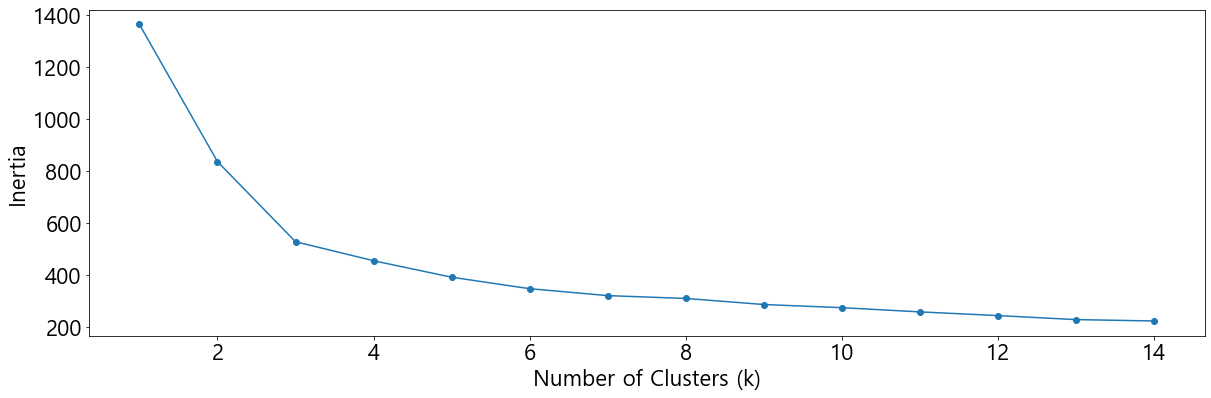

In [20]:
mm = MinMaxScaler()
mm_scaled = mm.fit_transform(dic['data1'])
samples = pd.DataFrame(mm_scaled)

# 최적의 k값 찾기-배껴온 코드
num_clusters = list(range(1, 15))	# K는 1 ~ 8사이의 정수입니다
inertias = []
# 각 K별로 모델을 생성하여 inertia를 측정합니다
for i in num_clusters:
    model = KMeans(n_clusters=i)
    model.fit(samples)
    inertias.append(model.inertia_)
# K에 따른 inertia의 변화를 시각화합니다
plt.plot(num_clusters, inertias, '-o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [21]:
# 스케일링과 클러스터링
mm = MinMaxScaler()
mm_scaled1 = mm.fit_transform(dic['data1'])
mm_scaled2 = mm.fit_transform(dic['data2'])
mm_scaled3 = mm.fit_transform(dic['data3'])
mm_scaled4 = mm.fit_transform(dic['data4'])
mm_scaled5 = mm.fit_transform(dic['data5'])
mm_scaled6 = mm.fit_transform(dic['data6'])
mm_scaled7 = mm.fit_transform(dic['data7'])
mm_scaled8 = mm.fit_transform(dic['data8'])
mm_scaled9 = mm.fit_transform(dic['data9'])
mm_scaled10 = mm.fit_transform(dic['data10'])
mm_scaled11 = mm.fit_transform(dic['data11'])
mm_scaled12 = mm.fit_transform(dic['data12'])
mm_scaled13 = mm.fit_transform(dic['data13'])
mm_scaled14 = mm.fit_transform(dic['data14'])
mm_scaled15 = mm.fit_transform(dic['data15'])
mm_scaled16 = mm.fit_transform(dic['data16'])
mm_scaled17 = mm.fit_transform(dic['data17'])
mm_scaled18 = mm.fit_transform(dic['data18'])

kmeans = KMeans(n_clusters=5, init='k-means++', random_state=np.random.RandomState(seed=1))

clusters1 = kmeans.fit(mm_scaled1)
dic['data1']['cluster'] = clusters1.labels_
clusters2 = kmeans.predict(mm_scaled2)
dic['data2']['cluster'] = clusters2
clusters3 = kmeans.predict(mm_scaled3)
dic['data3']['cluster'] = clusters3
clusters4 = kmeans.predict(mm_scaled4)
dic['data4']['cluster'] = clusters4
clusters5 = kmeans.predict(mm_scaled5)
dic['data5']['cluster'] = clusters5
clusters6 = kmeans.predict(mm_scaled6)
dic['data6']['cluster'] = clusters6
clusters7 = kmeans.predict(mm_scaled7)
dic['data7']['cluster'] = clusters7
clusters8 = kmeans.predict(mm_scaled8)
dic['data8']['cluster'] = clusters8
clusters9 = kmeans.predict(mm_scaled9)
dic['data9']['cluster'] = clusters9
clusters10 = kmeans.predict(mm_scaled10)
dic['data10']['cluster'] = clusters10
clusters11 = kmeans.predict(mm_scaled11)
dic['data11']['cluster'] = clusters11
clusters12 = kmeans.predict(mm_scaled12)
dic['data12']['cluster'] = clusters12
clusters13 = kmeans.predict(mm_scaled13)
dic['data13']['cluster'] = clusters13
clusters14 = kmeans.predict(mm_scaled14)
dic['data14']['cluster'] = clusters14
clusters15 = kmeans.predict(mm_scaled15)
dic['data15']['cluster'] = clusters15
clusters16 = kmeans.predict(mm_scaled16)
dic['data16']['cluster'] = clusters16
clusters17 = kmeans.predict(mm_scaled17)
dic['data17']['cluster'] = clusters17
clusters18 = kmeans.predict(mm_scaled18)
dic['data18']['cluster'] = clusters18

In [22]:
dic['data1'].groupby('cluster').count()

,거래금액(만원)_22/2,전세금(만원)_22/2,전월차,등락율,전세가율,인접역 수,전용면적,건축년도,SchoolDistrict,Brand,BrandPower
cluster,,,,,,,,,,,
0,1508,1508,1508,1508,1508,1508,1508,1508,1508,1508,1508
1,559,559,559,559,559,559,559,559,559,559,559
2,1619,1619,1619,1619,1619,1619,1619,1619,1619,1619,1619
3,91,91,91,91,91,91,91,91,91,91,91
4,314,314,314,314,314,314,314,314,314,314,314


In [23]:
dic['data9'].groupby('cluster').count()

,거래금액(만원)_20/2,전세금(만원)_20/2,전월차.8,등락율.8,전세가율.8,인접역 수,전용면적,건축년도,SchoolDistrict,Brand,BrandPower
cluster,,,,,,,,,,,
0,1563,1563,1563,1563,1563,1563,1563,1563,1563,1563,1563
1,559,559,559,559,559,559,559,559,559,559,559
2,1564,1564,1564,1564,1564,1564,1564,1564,1564,1564,1564
3,91,91,91,91,91,91,91,91,91,91,91
4,314,314,314,314,314,314,314,314,314,314,314


In [24]:
dic['data18'].groupby('cluster').count()

,거래금액(만원)_18/1,전세금(만원)_18/1,전월차,등락율,전세가율.17,인접역 수,전용면적,건축년도,SchoolDistrict,Brand,BrandPower
cluster,,,,,,,,,,,
0,1870,1870,1870,1870,1870,1870,1870,1870,1870,1870,1870
1,559,559,559,559,559,559,559,559,559,559,559
2,1257,1257,1257,1257,1257,1257,1257,1257,1257,1257,1257
3,91,91,91,91,91,91,91,91,91,91,91
4,314,314,314,314,314,314,314,314,314,314,314


In [25]:
# ID 다시 붙여주기
dic['data1'].set_index(ID, inplace=True)
dic['data1'] = dic['data1'].round(1)

dic['data2'].set_index(ID, inplace=True)
dic['data2'] = dic['data2'].round(1)

dic['data3'].set_index(ID, inplace=True)
dic['data3'] = dic['data3'].round(1)

dic['data4'].set_index(ID, inplace=True)
dic['data4'] = dic['data4'].round(1)

dic['data5'].set_index(ID, inplace=True)
dic['data5'] = dic['data5'].round(1)

dic['data6'].set_index(ID, inplace=True)
dic['data6'] = dic['data6'].round(1)

dic['data7'].set_index(ID, inplace=True)
dic['data7'] = dic['data7'].round(1)

dic['data8'].set_index(ID, inplace=True)
dic['data8'] = dic['data8'].round(1)

dic['data9'].set_index(ID, inplace=True)
dic['data9'] = dic['data9'].round(1)

dic['data10'].set_index(ID, inplace=True)
dic['data10'] = dic['data10'].round(1)

dic['data11'].set_index(ID, inplace=True)
dic['data11'] = dic['data11'].round(1)

dic['data12'].set_index(ID, inplace=True)
dic['data12'] = dic['data12'].round(1)

dic['data13'].set_index(ID, inplace=True)
dic['data13'] = dic['data13'].round(1)

dic['data14'].set_index(ID, inplace=True)
dic['data14'] = dic['data14'].round(1)

dic['data15'].set_index(ID, inplace=True)
dic['data15'] = dic['data15'].round(1)

dic['data16'].set_index(ID, inplace=True)
dic['data16'] = dic['data16'].round(1)

dic['data17'].set_index(ID, inplace=True)
dic['data17'] = dic['data17'].round(1)

dic['data18'].set_index(ID, inplace=True)
dic['data18'] = dic['data18'].round(1)

In [26]:
address = pd.concat([dic['data18'],dic['data17'],dic['data16'],dic['data15'],dic['data14'],dic['data13'],dic['data12'],dic['data11'],dic['data10'],dic['data9'],dic['data8'],dic['data7'],dic['data6'],dic['data5'],dic['data4'],dic['data3'],dic['data2'],dic['data1']], axis=1)
address

,거래금액(만원)_18/1,전세금(만원)_18/1,전월차,등락율,전세가율.17,인접역 수,전용면적,건축년도,SchoolDistrict,Brand,...,전월차,등락율,전세가율,인접역 수,전용면적,건축년도,SchoolDistrict,Brand,BrandPower,cluster
ID,,,,,,,,,,,,,,,,,,,,,
서울특별시 강남구 개포동 개포6차우성아파트1동~8동 80,129125.0,42166.7,5375.0,4.162633,32.7,0,80,1987.0,3,0,...,3666.7,1.7,27.1,0,80,1987.0,3,0,0,4
서울특별시 강남구 개포동 개포주공1단지 40,145736.8,10166.7,24058.228571,16.507998,7.0,1,40,1982.0,3,0,...,0.0,0.0,5.6,1,40,1982.0,3,0,0,4
서울특별시 강남구 개포동 개포주공5단지 60,136666.7,42678.6,0.0,0.0,31.2,1,60,1983.0,3,0,...,0.0,0.0,21.8,1,60,1983.0,3,0,0,4
서울특별시 강남구 개포동 개포주공5단지 80,177416.7,45000.0,0.0,0.0,25.4,1,80,1983.0,3,0,...,0.0,0.0,22.1,1,80,1983.0,3,0,0,4
서울특별시 강남구 개포동 개포주공6단지 50,125900.0,37909.1,11500.0,9.134234,30.1,1,50,1983.0,3,0,...,0.0,0.0,22.8,1,50,1983.0,3,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
서울특별시 중랑구 중화동 중화동건영아파트 60,25000.0,2500.0,1500.0,6.0,10.0,1,60,1998.0,0,0,...,0.0,0.0,50.8,1,60,1998.0,0,0,0,2
서울특별시 중랑구 중화동 태능에셈빌 80,35000.0,15000.0,0.0,0.0,42.9,1,80,2005.0,0,0,...,0.0,0.0,21.1,1,80,2005.0,0,0,0,0
서울특별시 중랑구 중화동 한신아파트 50,31756.2,24571.4,0.0,0.0,77.4,5,50,1997.0,0,0,...,0.0,0.0,52.9,5,50,1997.0,0,0,0,0


In [27]:
address.to_excel('data/last_last.xlsx')